<a href="https://colab.research.google.com/github/dinaOuahbi/05_Hatzis_2011-BRCA-Prediction/blob/main/thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [319]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival

In [320]:
df_r = pd.read_excel('/content/GLI_rad.xlsx')
df_s = pd.read_excel('/content/GLI_surg.xlsx')

In [321]:
df_r['GROUP'] = 'rad'
df_s['GROUP'] = 'surg'
df = pd.concat([df_r, df_s])
df.head()

,NOM,PRENOM,DDN,AGE,SEXE,DIABETE,CŒUR,REINS,IMMUNODEP,TABAC,...,KPS2,EPILEPSIE,AEG,DEFICIT,CTC2,DATECHIMIO2,FINCHIMIO2,DECES,DATEDECES,GROUP
0,MATHIEU,JOSEPH,1973-12-01 00:00:00,45,H,NON,OUI,NON,NON,OUI,...,80.0,1.0,1.0,1.0,160.0,2020-05-26 00:00:00,2020-09-28 00:00:00,NON,NaN,rad
1,REBOUILLAT,PASCAL,1968-02-20 00:00:00,47,H,NON,NON,NON,NON,OUI,...,60.0,1.0,0.0,0.0,60.0,2016-09-01 00:00:00,NaN,OUI,2016-09-01 00:00:00,rad
2,DANNER,MARTINE,1959-03-27 00:00:00,54,F,NON,NON,NON,OUI,OUI,...,70.0,1.0,1.0,1.0,60.0,2019-05-06 00:00:00,2019-09-23 00:00:00,OUI,2020-09-17 00:00:00,rad
3,LEGROS,ALETH,1956-12-15 00:00:00,56,F,NON,NON,OUI,NON,NON,...,40.0,0.0,0.0,1.0,120.0,2015-10-16 00:00:00,2016-01-15 00:00:00,OUI,2016-04-12 00:00:00,rad
4,GLARMET,YVAN,1957-10-25 00:00:00,59,H,NON,OUI,NON,NON,OUI,...,80.0,1.0,0.0,1.0,60.0,2019-04-17 00:00:00,2020-10-12 00:00:00,OUI,2021-02-10 00:00:00,rad


In [322]:
df['ID'] = df[['NOM', 'PRENOM']].agg('_'.join, axis=1)
df.drop(['NOM', 'PRENOM'], axis=1, inplace=True)
df.set_index('ID', inplace=True)

Text(0, 0.5, 'NAN coutns (RAD)')

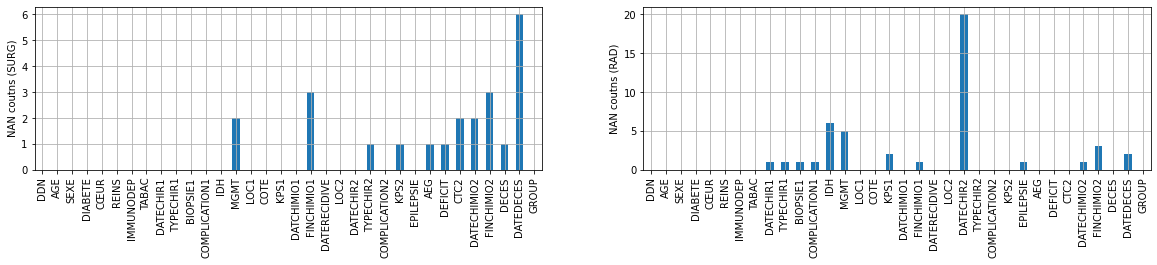

In [323]:
# NA
plt.figure(figsize=(20,3))
plt.subplot(1,2,1)
df[df['GROUP'] =='surg'].isna().sum(axis=0).plot(kind='bar')
plt.grid(b='on')
plt.ylabel('NAN coutns (SURG)')

plt.subplot(1,2,2)
df[df['GROUP'] =='rad'].isna().sum(axis=0).plot(kind='bar')
plt.grid(b='on')
plt.ylabel('NAN coutns (RAD)')

In [324]:
# KPS1 / KPS2
def replace_KPS(data_x, col, dich):
  temp = list()
  for i in data_x[col]:
    if i>dich:
      temp.append(1)
    elif i<=dich:
      temp.append(0)
    else:
      temp.append(i)
  data_x[col] = temp

replace_KPS(df, 'KPS1', 70)
replace_KPS(df, 'KPS2', 70)

In [325]:
# CTC2
for i in df['CTC2']:
  if i <= 40:
    df['CTC2'] = df['CTC2'].replace({i:'low'})
  elif i>=60 and i<=80:
    df['CTC2'] = df['CTC2'].replace({i:'medium'})
  else:
    df['CTC2'] = df['CTC2'].replace({i:'hight'})


In [326]:
# convert to object 
for col in df.select_dtypes('float').columns.to_list():
  df[col]=df[col].astype('object')
  print(df[col].dtypes)

object
object
object
object
object


In [327]:
# LOC2
df['LOC2']=df['LOC2'].astype('object')

Text(0, 0.5, '')

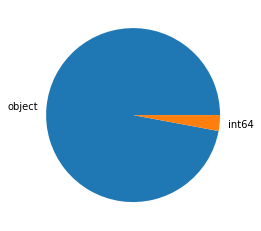

In [328]:
df.dtypes.value_counts().plot.pie()
plt.ylabel('')

In [329]:
def generate_status(time_l):
  stat = list()
  for i in time_l:
    if i==0:
      stat.append(False)
    else:
      stat.append(True)
  return stat

In [330]:
def get_delta_time(df, start, end):
  d = df[end] - df[start]
  d = pd.Series(d).fillna(pd.Timedelta(days=0)).tolist()
  time_l = [i.days for i in d]
  status = generate_status(time_l)
  return time_l, status

In [331]:
# to date time
my_dates = ['DATECHIR1','DATERECIDIVE','FINCHIMIO2','DATEDECES']
for col in my_dates:
  for row in df[col]:
    if isinstance(row, str):
      new_date = pd.to_datetime(row.strip(), format='%d/%m/%Y')
      df[col] = df[col].replace({row:new_date})

In [332]:
# generqte times qnd status
df['PFS1'],df['PROG1'] = get_delta_time(df, 'DATECHIR1', 'DATERECIDIVE')
df['PFS2'], df['PROG2'] = get_delta_time(df, 'DATERECIDIVE', 'FINCHIMIO2')
df['OS1'], df['DCD1'] = get_delta_time(df, 'DATECHIR1','DATEDECES')
df['OS2'], df['DCD2'] = get_delta_time(df, 'DATERECIDIVE','DATEDECES')

In [333]:
# REBOUILLAT_PASCAL prend la chimio2 avant sa premiere recidive ??? a revoir avec Audrey
print
(
    df['DATERECIDIVE'][df.index=='REBOUILLAT_PASCAL'],
    df['DATECHIMIO2'][df.index=='REBOUILLAT_PASCAL']
)

(ID
 REBOUILLAT_PASCAL   2016-10-01
 Name: DATERECIDIVE, dtype: datetime64[ns], ID
 REBOUILLAT_PASCAL    2016-09-01 00:00:00
 Name: DATECHIMIO2, dtype: object)

In [334]:
df['OS2']['REBOUILLAT_PASCAL'] = abs(df['OS2']['REBOUILLAT_PASCAL'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [272]:
#df.to_csv('merge_df.csv')

**DESCRIPTION**

In [335]:
data_x = df[['SEXE', 'DIABETE', 'CŒUR', 'REINS', 'IMMUNODEP', 'TABAC','TYPECHIR1', 'BIOPSIE1',
 'COMPLICATION1', 'IDH', 'MGMT', 'LOC1', 'COTE','KPS1','LOC2','TYPECHIR2','COMPLICATION2',
 'KPS2', 'EPILEPSIE', 'AEG', 'DEFICIT', 'CTC2', 'DECES', 'GROUP']]

In [336]:
def count_object(df):
  dic = dict()
  for col in df.columns:
    dic_bis = dict()
    for i in range(len(df[col].value_counts().index)):
      dic_bis[df[col].value_counts().index[i]] = df[col].value_counts().values[i]
    dic[col] = dic_bis
  return pd.DataFrame(dic.items(), columns=['col','val'])

In [337]:
val_counts = pd.merge(
    count_object(data_x[data_x['GROUP']=='surg']),
    count_object(data_x[data_x['GROUP']=='rad']),
    on='col'
)
val_counts = val_counts.rename(columns={'val_x':'surgery cohort',
                           'val_y':'radioT cohort'})

In [289]:
#val_counts.to_csv('val_counts.csv')

In [338]:
def describe_variables(class_, df):
  describe = pd.DataFrame(index=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
  for col in df.select_dtypes('int'):
    describe[col] = df[col][df['GROUP']==class_].describe().values
  return describe

In [315]:
#describe_variables('rad', df).to_csv('describe_rad_cohort.csv')

In [316]:
#describe_variables('surg', df).to_csv('describe_surg_cohort.csv')

**chi2 test (categories)**

In [379]:
import scipy.stats as stats
chi_test = pd.DataFrame(columns=['chi_square','p_value', 'dof'])
for col in data_x.columns:
  data_crosstab = pd.crosstab(data_x['GROUP'], data_x[col],margins=True, margins_name="Total")
  chi_test.loc[col, :] = stats.chi2_contingency(data_crosstab)[:3]

In [386]:
#chi_test.to_csv('chi_square_test.csv')

**wilconxon test (int)**

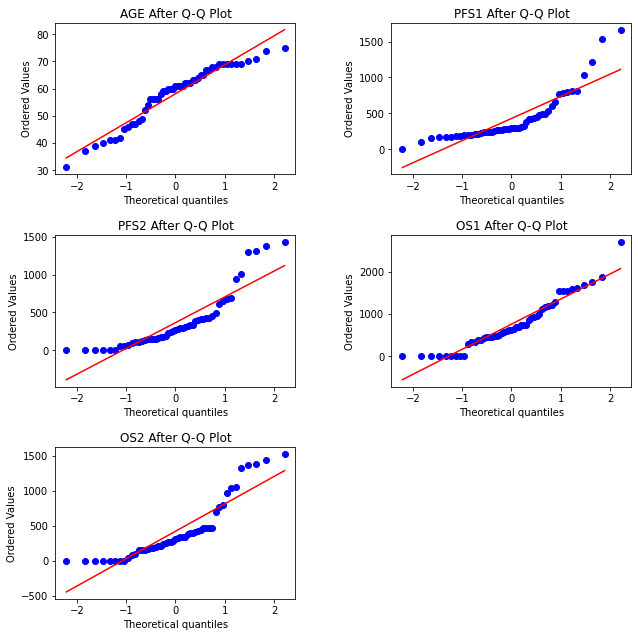

In [403]:
# show the violation between normality for some variables ===> because wilcoxon test ask for that
plt.figure(figsize=(10,10))
for i,col in enumerate(df.select_dtypes('int')):
  plt.subplot(3,2,i +1)
  stats.probplot(df[col], dist="norm", plot=plt)
  plt.title(f"{col} After Q-Q Plot")
  # set the spacing between subplots
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,  hspace=0.4)
#plt.savefig("BP_After_QQ.png")

In [428]:
a = np.array(df['AGE'])
np.random.choice()

TypeError: ignored

22
29


ValueError: ignored

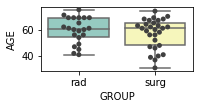

In [430]:
from scipy.stats import wilcoxon
for i,col in enumerate(df.select_dtypes('int')):
  plt.subplot(3,2,i +1)
  sns.boxplot(x="GROUP", y=col,data=df, palette="Set3")
  sns.swarmplot(x="GROUP", y=col,data=df, color=".25")
  surg = np.array(df[col][df['GROUP']=='surg'])
  rad  = np.array(df[col][df['GROUP']=='rad'])
  rad = np.random.choice(surg, 22)
  print(len(rad))
  print(len(surg))
  w, p = wilcoxon(surg, rad)
  plt.title(f"{col} | {p}")
  ccl = False
  if p <= 0.05:
    ccl = True
  print(col, w, p, ccl)

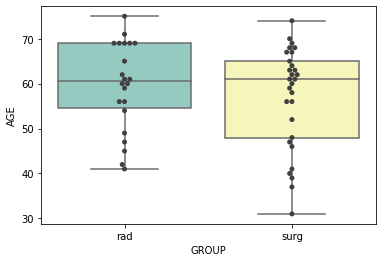

In [423]:
import seaborn as sns
sns.boxplot(x="GROUP", y="AGE",data=df, palette="Set3")
sns.swarmplot(x="GROUP", y="AGE",data=df, color=".25")